In [1]:
from common import *
disable_fig_save = False 
save_loc = 'plots'
save_prefix="pathfinding"
config_common(disable_fig_save=disable_fig_save, save_loc=save_loc, save_prefix=save_prefix)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import warnings

%config InlineBackend.figure_format = 'svg'

from os import path
from typing import Dict, List, Set

import matplotlib.ticker as mtick
import matplotlib as mpl
from scipy.stats.mstats import gmean
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, ScalarFormatter, LogLocator)
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib import rc

import seaborn as sns

In [3]:
init_notebook()
figsize = (7,1.65)
fontsize = 12
Fig.config(fontsize, figsize)

In [4]:
dataf = "../../data/linkedlist.csv"

In [5]:
!sha256sum $dataf

29080a58955eef925e3f7350c7de0b83837958439d64440140b2eb843e92df74  ../../data/linkedlist.csv


In [6]:
df = pd.read_csv(dataf, index_col=None)
df = df.set_index('workload')
df = df/10**9

In [7]:
pmdk_col = df['pmdk']
df_norm = df.copy(deep=True)
for col in df:
    df_norm[col] = df[col]/pmdk_col
df_norm

,pmdk,snashot,msync
workload,,,
insert,1.0,0.647677,3.035295
delete,1.0,0.620331,293.952127
traverse,1.0,0.198965,0.213074


Plot saved as `plots/pathfinding/linkedlist.png.png`

Plot saved as `plots/pathfinding/linkedlist.png.png`

Using pdfcrop on `plots/pathfinding/linkedlist.png.png` with command `pdfcrop plots/pathfinding/linkedlist.png.pdf plots/pathfinding/linkedlist.png.pdf`

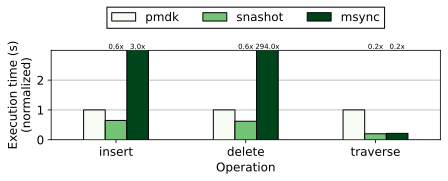

In [11]:
ax = df_norm.plot.bar(**Fig.get_kwargs(cmap='Greens'))
f = Fig(ax)
f.fmt_legend()
f.fmt_label('Operation', 'Execution time (s)\n(normalized)')
f.add_bar_labels([False, True, True], fontsize=fontsize-5)
f.xrot(rot=0)
f.fmt_grid(axis='y')
ax.set_ylim((0,3))
ax.set_yticks(np.arange(0, 3, 1))
save_fig('linkedlist.png')